## Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5.1. Выполните когортный анализ пользователей.

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python, раздел “Стильный урок”, степ 5. (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (23 балла)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
from datetime import datetime
import json
import numpy as np
from pandas import Period
from datetime import timedelta

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
def df_reader(public_key_df):
    final_url_customers = base_url + urlencode(dict(public_key=public_key_df))
    return pd.read_csv(requests.get(final_url_customers).json()['href'])

In [3]:
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_order_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [4]:
df_customers = df_reader(public_key_customers)
df_orders = df_reader(public_key_orders)
df_order_items = df_reader(public_key_order_items)

In [5]:
# df_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/data_for_first_project/olist_customers_dataset.csv')
# df_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/data_for_first_project/olist_orders_dataset.csv')
# df_order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-igo-alekseev/data_for_first_project/olist_order_items_dataset.csv')

In [6]:
# Конвертируем в формат времени нужные столбцы
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'], format='%Y-%m-%d %H:%M:%S')

### Задание 1. 
Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

Покупка совершена, если пользователю выдан чек о покупке(order_id), заказ не отменен, доступен и оплата прошла (есть время подтверждения оплаты заказа).
Значит объединив датасеты df_customers и df_orders (inner merge) по customer_id, мы отсеем тех, кто не создал заказ.
Так же фильтруем на отмену заказа и доступность.

**Датасет пользователей, которые совершили хотя бы 1 покупку (без "оплата прошла"):**

In [7]:
df_purchase_done = df_customers.merge(df_orders, on='customer_id').query('order_status != "canceled" and order_status != "unavailable"')

**Ищем тех, у кого не прошла оплата:**

Тут замечены заказы со статусом "delivered" и "created", у которых нет записи о времени подтверждения оплаты заказа. Решил исключить эти позиции.

In [8]:
df_purchase_done['approved_isna'] = df_purchase_done.order_approved_at.isna()
df_order_approved_at_isna = df_purchase_done.query('approved_isna==True')
df_order_approved_at_isna.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,approved_isna
8970,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,13225,varzea paulista,SP,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,True
13047,4ee64f4bfc542546f422da0aeb462853,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,True
13890,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,True
20863,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,True
22703,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,True


**Убираем заказы с 'approved_isna == True':**

In [9]:
df_purchase_done = df_purchase_done.query('approved_isna==False')

**Получаем количесво пользователей с 1 покупкой:**

Группируем по уникальному id пользователя, считаем количество его чеков о покупке (кол-во покупок), фильтруем по количеству покупок = 1.

In [10]:
one_purchase_done_df_sum = df_purchase_done \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values('order_id', ascending=False) \
    .query('order_id == 1') \
    .order_id.sum()
one_purchase_done_df_sum

92087

### Задание 2. 

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

Причины, по которой заказы могут быть не доставлены две: заказ canceled или unavailable, потому что остальные состояния говорят о процессе работы по оформлению или выполнению заказа (доставки).

 **Датасет совершенных заказов без "delivered":**

In [11]:
df_not_delivered = df_customers.merge(df_orders, on='customer_id').query('order_status != "delivered"')

Также заказ могут не оплатить и тогда его не должны доставлять.
Но среди неоплаченных есть только 'canceled' и 'created', 'canceled' мы учтем далее, а 'created' это нормальное состояние
только что созданного заказа.

In [12]:
df_not_delivered_not_payed = df_not_delivered.loc[df_not_delivered.order_approved_at.isna() == True]
df_not_delivered_not_payed.order_status.unique()

array(['canceled', 'created'], dtype=object)

**Меняем формат времени к год\месяц:**

In [13]:
df_not_delivered['year_month'] = df_not_delivered["order_purchase_timestamp"].dt.to_period("M")
df_not_delivered.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,2018-03
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24,2018-04
70,4c7241af24b5344cb01fe687643de4fe,b157c176c3fe04914fde33f2dc8b878a,60336,fortaleza,CE,ad380680e87dea0f2abf5cd5bace626c,shipped,2018-01-21 15:54:02,2018-01-22 13:52:41,2018-01-24 18:26:40,NaT,2018-02-20,2018-01
79,f6529ffebe6b3440d45d89604a4239ac,e5dbefdfdf3eff75c8e6cd655f128279,26272,nova iguacu,RJ,cc07a8fdd3a8e94d683c8142a117dbc1,shipped,2018-01-11 17:11:11,2018-01-12 17:49:45,2018-01-17 16:56:32,NaT,2018-02-09,2018-01
100,ae76a4650235ab18764708174f1da31e,2b6082a140c439e2df870c85b0aa5e88,2983,sao paulo,SP,4c33ec562d9dc5655e160913aa86eb53,shipped,2017-08-11 23:47:48,2017-08-12 00:03:51,2017-08-14 13:24:58,NaT,2017-09-11,2017-08


**Оказывается есть, еще просроченные заказы, отмечаем их как overdue в таблице по фильтру:**

Нас инетерсуют заказы, которые были оплачены, которым выдали дату доставки ожидаемую, но данных по дате доставки нет, а число уже равно дате последней записи, ну и при этом они конечно же не имеют статус отменен или недоступен.

In [14]:
condition = 'order_estimated_delivery_date < order_estimated_delivery_date.max() and order_delivered_customer_date.isna() \
    and order_status != "canceled" and order_status != "unavailable"'
df_not_delivered.at[df_not_delivered.query(condition).index, 'order_status'] = 'overdue'

In [15]:
df_not_delivered.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,2018-03
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,overdue,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24,2018-04
70,4c7241af24b5344cb01fe687643de4fe,b157c176c3fe04914fde33f2dc8b878a,60336,fortaleza,CE,ad380680e87dea0f2abf5cd5bace626c,overdue,2018-01-21 15:54:02,2018-01-22 13:52:41,2018-01-24 18:26:40,NaT,2018-02-20,2018-01
79,f6529ffebe6b3440d45d89604a4239ac,e5dbefdfdf3eff75c8e6cd655f128279,26272,nova iguacu,RJ,cc07a8fdd3a8e94d683c8142a117dbc1,overdue,2018-01-11 17:11:11,2018-01-12 17:49:45,2018-01-17 16:56:32,NaT,2018-02-09,2018-01
100,ae76a4650235ab18764708174f1da31e,2b6082a140c439e2df870c85b0aa5e88,2983,sao paulo,SP,4c33ec562d9dc5655e160913aa86eb53,overdue,2017-08-11 23:47:48,2017-08-12 00:03:51,2017-08-14 13:24:58,NaT,2017-09-11,2017-08


**Сколько заказов в месяц в среднем не доставляется по разным причинам:**

In [16]:
reasons = ["canceled", "unavailable", 'overdue']
avg_month_not_delivered = df_not_delivered \
    .query('order_status in @reasons') \
    .groupby(['order_status', 'year_month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'avg_month_not_delivered'}) \
    .avg_month_not_delivered.mean().round(3)

In [17]:
avg_month_not_delivered

43.574

**Детализация по причинам:**

In [18]:
avg_month_not_delivered_reason = df_not_delivered \
    .query('order_status in @reasons') \
    .groupby(['order_status', 'year_month'], as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby(['order_status']) \
    .agg({'order_id': 'mean'}) \
    .rename(columns={'order_id': 'avg_month_not_delivered'}) \
    .reset_index() \
    .round(2)


In [19]:
avg_month_not_delivered_reason

,order_status,avg_month_not_delivered
0,canceled,26.04
1,overdue,75.17
2,unavailable,29.00


### Задание 3. 
По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

**Если "покупается", то берем таблицу из 1 задания df_purchase_done (совершенных покупок) и добавляем к ней df_order_items по order_id:**

In [20]:
all_data_purchase_done = df_purchase_done.merge(df_order_items, on='order_id') 

**Добавяем столбец с днем недели покупки (подтверждение оплаты):**

In [21]:
all_data_purchase_done['day_of_the_week'] = all_data_purchase_done['order_approved_at'].dt.day_name()

**По каждому товару (product_id) день недели, в который товар чаще всего покупается:**

In [22]:
all_data_purchase_done_most_dayweek = all_data_purchase_done \
    .groupby(['product_id', 'day_of_the_week']) \
    .agg({'order_approved_at': 'count'}) \
    .reset_index() \
    .groupby(['product_id']).max() \
    .sort_values('order_approved_at', ascending=False) \
    .rename(columns={'order_approved_at': 'purchase_count'}) \
    
all_data_purchase_done_most_dayweek.head()



,day_of_the_week,purchase_count
product_id,,
aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,119
53b36df67ebb7c41585e8d54d6772e08,Wednesday,105
422879e10f46682990de24d770e7f83d,Wednesday,89
99a4788cb24856965c36a24e339b6058,Wednesday,82
368c6c730842d78016ad823897a372db,Wednesday,80


### Задание 4. 
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

**Берем датасет из 1 задания с совершенными покупками (заказами). 1 покупкой будем считать 1 заказ, а не 1 товар:**

In [23]:
df_purchase_done.drop('approved_isna', axis=1, inplace=True)

**Добавляем столбец с год\месяц и столбец со средним количеством недель в месяце:**

In [24]:
df_purchase_done['year_month'] = df_purchase_done['order_approved_at'].dt.to_period("M")
df_purchase_done['weeks_month'] = (df_purchase_done['year_month'].dt.days_in_month / 7).round(2)


In [25]:
df_purchase_done.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,weeks_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,4.43
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,4.43
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,4.43


**Считаем количество покупок(заказов) каждого уникального пользователя по месяцам:**

In [26]:
df_purchase_number = df_purchase_done \
    .groupby(['customer_unique_id', 'year_month', 'weeks_month']) \
    .agg({'order_id':'count'}) \
    .sort_values(['order_id'], ascending=False) \
    .rename(columns={'order_id': 'purchase_count'}) \
    .reset_index()

**Добавляем колонку "средне количество покупок в неделю":**

In [27]:
df_purchase_number['avg_week_purchase'] = (df_purchase_number.purchase_count / df_purchase_number.weeks_month).round(2)

**Сколько у каждого из пользователей в среднем покупок в неделю по месяцам:**

In [28]:
df_purchase_number_month = df_purchase_number \
    .groupby(['customer_unique_id', 'year_month']) \
    .agg({'avg_week_purchase': 'mean'}) \
    .reset_index()

df_purchase_number_month.head()

,customer_unique_id,year_month,avg_week_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.23


**Сколько у каждого из пользователей в среднем покупок в неделю:**

In [29]:
df_purchase_number_no_month = df_purchase_number \
    .groupby('customer_unique_id') \
    .agg({'avg_week_purchase': 'mean'}) \
    .reset_index()

df_purchase_number_no_month.head()

,customer_unique_id,avg_week_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.23
2,0000f46a3911fa3c0805444483337064,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,0.23
4,0004aac84e0df4da2b147fca70cf8255,0.23


**Обращаемся по юзеру, проверяем срез данных (среднее в неделю без учета месяца):**

In [30]:
df_purchase_number_no_month.loc[df_purchase_number_no_month.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,avg_week_purchase
52349,8d50f5eadf50201ccdcedfb9e2ac8455,0.363


**Обращаемся по юзеру, проверяем срез данных (среднее в неделю с учетом месяца):**

In [31]:
df_purchase_number.loc[df_purchase_number.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,year_month,weeks_month,purchase_count,avg_week_purchase
16,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08,4.43,3,0.68
598,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07,4.43,2,0.45
607,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07,4.43,2,0.45
611,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05,4.43,2,0.45
613,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10,4.43,2,0.45
15125,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11,4.29,1,0.23
15159,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09,4.29,1,0.23
15172,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08,4.43,1,0.23
15186,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06,4.29,1,0.23
15187,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05,4.43,1,0.23


### Задание 5.
5.1. Выполните когортный анализ пользователей.

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. 
Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 8-го урока python,
раздел “Стильный урок”, степ 5. (15 баллов)

Перед проведением когортного анализа определяют четыре параметра:

Признак формирования когорты — действие, которое объединяет людей в группу: первый визит, покупка, установка, регистрация и т.п.
Размер когорты — временной интервал: день, неделя, месяц.
Отчетный период — время исследования поведения групп.
Анализируемый ключевой показатель: ROI, Retention Rate, LTV и т.д.
Retention rate = количество активных пользователей на конец периода / 
количество активных пользователей на начало периода * 100%

Признак формирования когорты — создание заказа

Размер когорты — временной интервал: месяц (берем дату оплаты, приводим к месяцу)

Отчетный период — с января по декабрь 2017 год

Анализируемый ключевой показатель: Retention Rate


**Берем пользователей с совершенной оплатой:**

In [32]:
df_purchase_done.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,weeks_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,4.43
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,4.43
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,4.43


**Находим дату первого заказа ждя каждого уникального пользователя:**

In [33]:
df_first_approved_order = df_purchase_done \
    .groupby('customer_unique_id') \
    .agg({'order_approved_at': 'min'}) \
    .rename(columns={'order_approved_at': 'first_approved_order'}) \
    .reset_index() \
    .sort_values('first_approved_order')

df_first_approved_order.head()

,customer_unique_id,first_approved_order
48742,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38
7561,14359ea0c7a105749c0a56478825b015,2016-10-04 09:43:32
50296,87776adb449c551e74c13fc34f036105,2016-10-04 10:19:23
50758,88bc832f104b6dd684a17dbb1b76e778,2016-10-04 10:25:46
52317,8d3a54507421dbd2ce0a1d58046826e0,2016-10-04 10:28:07


In [34]:
df_first_approved_order['cohort'] = df_first_approved_order['first_approved_order'].dt.to_period("M")

**Добавляем дату первого заказа в наш датафрейм:**

In [35]:
df_customers_with_first_approved_orders = df_purchase_done.merge(df_first_approved_order, on='customer_unique_id')
df_customers_with_first_approved_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,weeks_month,first_approved_order,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,4.43,2017-05-16 15:22:12,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,4.43,2018-01-12 20:58:32,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,4.43,2018-05-20 16:19:10,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,4.43,2018-03-13 17:29:19,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,4.43,2018-07-29 10:10:09,2018-07


**Считаем разницу между последеней оплатой заказа и первой в месяцах, округляем до целого:**

In [36]:
df_customers_with_first_approved_orders['diff_months'] = ((df_customers_with_first_approved_orders['order_approved_at'] - df_customers_with_first_approved_orders['first_approved_order']) / np.timedelta64(1, 'M')).round(0) 
df_customers_with_first_approved_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,weeks_month,first_approved_order,cohort,diff_months
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,4.43,2017-05-16 15:22:12,2017-05,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,4.43,2018-01-12 20:58:32,2018-01,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,4.43,2018-05-20 16:19:10,2018-05,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,4.43,2018-03-13 17:29:19,2018-03,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,4.43,2018-07-29 10:10:09,2018-07,0.0


**Подготавливаем данные для анализа, учитываем период из задания (с января по декабрь 2017 год):**

Делим на когорты по отчетному периоду (месяц), считаем количество уникальных пользователей на каждый период.

In [37]:
df_cohorts = df_customers_with_first_approved_orders \
    .query('cohort >= "2017-01" & cohort <= "2017-12"') \
    .groupby(['cohort', 'diff_months']) \
    .agg({'customer_unique_id': 'nunique'}) \
    .reset_index() \
    .rename(columns={'customer_unique_id': 'customer_count', 'diff_months': 'Cohort_period'})
df_cohorts.head()

,cohort,Cohort_period,customer_count
0,2017-01,0.0,716
1,2017-01,1.0,2
2,2017-01,2.0,1
3,2017-01,3.0,2
4,2017-01,4.0,3


**Считаем retention в долях и добавляем в датасет:**

In [38]:
cohort_names = list(df_cohorts.cohort.unique())
def retention(df):
    result = []
    for c in cohort_names:
        result.append(list(df.loc[df.cohort == c].customer_count / df.loc[df.cohort == c].customer_count.iloc[0]))
    return result

result_retention = retention(df_cohorts)

retention_percent = []
for lst in result_retention:
    for value in lst:
        retention_percent.append(value)

In [39]:
df_cohorts['retention'] = retention_percent
df_cohorts

,cohort,Cohort_period,customer_count,retention
0,2017-01,0.0,716,1.000000
1,2017-01,1.0,2,0.002793
2,2017-01,2.0,1,0.001397
3,2017-01,3.0,2,0.002793
4,2017-01,4.0,3,0.004190
...,...,...,...,...
166,2017-12,4.0,12,0.002146
167,2017-12,5.0,13,0.002325
168,2017-12,6.0,8,0.001431
169,2017-12,7.0,3,0.000537


**Создаем своднуу таблицу:**

In [40]:
df_cohorts_pivot = df_cohorts.pivot(index='cohort', columns='Cohort_period', values='retention')

df_cohorts_pivot

Cohort_period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.002793,0.001397,0.002793,0.004190,NaN,0.004190,0.001397,0.001397,NaN,0.005587,0.004190,0.005587,0.002793,NaN,0.002793,0.001397,0.004190,NaN,0.001397
2017-02,1.0,0.002987,0.001792,0.001195,0.004779,0.001195,0.002987,0.001195,0.000597,0.001792,0.001195,0.003584,0.000597,0.001792,0.001195,0.000597,0.000597,0.001792,0.000597,NaN
2017-03,1.0,0.005426,0.002326,0.004651,0.003101,0.001550,0.002713,0.002326,0.001938,0.002326,0.003488,0.001550,0.001938,0.001550,0.001938,0.001550,0.000775,0.001550,NaN,NaN
2017-04,1.0,0.006084,0.001738,0.001738,0.002173,0.003477,0.003042,0.002173,0.003911,0.002608,0.001738,0.001304,0.000435,0.000869,0.000435,0.000869,0.001304,NaN,NaN,NaN
2017-05,1.0,0.005080,0.004798,0.003951,0.003951,0.003387,0.003105,0.001693,0.002540,0.002822,0.002822,0.002822,0.001693,0.001129,0.001693,0.002540,NaN,NaN,NaN,NaN
2017-06,1.0,0.003859,0.004823,0.003215,0.003215,0.002251,0.004180,0.002894,0.001286,0.003215,0.002251,0.003537,0.000965,0.002572,0.001286,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.004502,0.002913,0.002648,0.002383,0.002913,0.002648,0.001589,0.001854,0.002119,0.002119,0.002913,0.001324,0.002383,0.000265,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.005778,0.004333,0.003130,0.003852,0.004333,0.003130,0.002167,0.001926,0.001685,0.001926,0.002167,0.001204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.007078,0.005614,0.003173,0.004393,0.002929,0.001220,0.002441,0.003417,0.001953,0.001709,0.001220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Меняем стиль данных:**

In [41]:
ur_style = (df_cohorts_pivot
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

Cohort_period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.28%,0.14%,0.28%,0.42%,,0.42%,0.14%,0.14%,,0.56%,0.42%,0.56%,0.28%,,0.28%,0.14%,0.42%,,0.14%
2017-02,100.00%,0.30%,0.18%,0.12%,0.48%,0.12%,0.30%,0.12%,0.06%,0.18%,0.12%,0.36%,0.06%,0.18%,0.12%,0.06%,0.06%,0.18%,0.06%,
2017-03,100.00%,0.54%,0.23%,0.47%,0.31%,0.16%,0.27%,0.23%,0.19%,0.23%,0.35%,0.16%,0.19%,0.16%,0.19%,0.16%,0.08%,0.16%,,
2017-04,100.00%,0.61%,0.17%,0.17%,0.22%,0.35%,0.30%,0.22%,0.39%,0.26%,0.17%,0.13%,0.04%,0.09%,0.04%,0.09%,0.13%,,,
2017-05,100.00%,0.51%,0.48%,0.40%,0.40%,0.34%,0.31%,0.17%,0.25%,0.28%,0.28%,0.28%,0.17%,0.11%,0.17%,0.25%,,,,
2017-06,100.00%,0.39%,0.48%,0.32%,0.32%,0.23%,0.42%,0.29%,0.13%,0.32%,0.23%,0.35%,0.10%,0.26%,0.13%,,,,,
2017-07,100.00%,0.45%,0.29%,0.26%,0.24%,0.29%,0.26%,0.16%,0.19%,0.21%,0.21%,0.29%,0.13%,0.24%,0.03%,,,,,
2017-08,100.00%,0.58%,0.43%,0.31%,0.39%,0.43%,0.31%,0.22%,0.19%,0.17%,0.19%,0.22%,0.12%,,,,,,,
2017-09,100.00%,0.71%,0.56%,0.32%,0.44%,0.29%,0.12%,0.24%,0.34%,0.20%,0.17%,0.12%,,,,,,,,


**Отвечаем на вопрос "выявите когорту с самым высоким retention на 3-й месяц":**


In [42]:
round(df_cohorts_pivot.div(df_cohorts_pivot.iloc[:,0], axis = 0).mul(100), 2)[2].idxmax()

Period('2017-09', 'M')

### Задание 6. 
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, 
F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. 
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, 
frequency и monetary для интерпретации этих кластеров. Пример такого описания: 
RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, 
frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (23 балла)

**Берем датафрейм с 3 исходными таблицами, с учетом сделанных покупок:**

In [43]:
all_data_purchase_done = all_data_purchase_done.drop('day_of_the_week', axis=1).drop('approved_isna', axis=1)
all_data_purchase_done.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


**Считаем общую стоимость каждого уникального заказа c учетом даты оплаты:**

In [44]:
df_total_price = all_data_purchase_done \
    .groupby(['customer_unique_id', 'order_approved_at', 'order_id']) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'order_total_price'}) \
    .reset_index()

**Моделируем анализ, установив текущую дату на один день после последней покупки:**

Эта дата будет использоваться в качестве ориентира для расчета показателя Recency.

In [45]:
now = df_total_price['order_approved_at'].max() + timedelta(days=1)
now

Timestamp('2018-09-04 17:40:06')

**Исследуемый период 1 год:**

In [46]:
period = 365

**Расчет Recency, Frequency and Monetary для каждого покупателя:**

In [47]:
# Количество дней с последнего заказа
df_total_price['days_since_order'] = df_total_price['order_approved_at'].apply(lambda x: (now - x).days)
#Определяем датасет с учетом периода
p = now - timedelta(days=period)
df_period = df_total_price.query('order_approved_at >= @p').sort_values('order_approved_at')

df_period.head()

,customer_unique_id,order_approved_at,order_id,order_total_price,days_since_order
10086,1a1ef63703ffae2066391f77fd8f44ce,2017-09-04 18:04:23,2322d66af2e4fa6e3d854b5249ca9f6a,64.90,364
87415,e38413a14a7b79e330ea4d62546f6e23,2017-09-04 18:15:16,cb5ece4890234f69f2371e3179e42f73,180.00,364
25797,432ee7edf0be5950fe2bc6409d3af9b7,2017-09-04 18:24:00,430bd310105f069ac72ef7758f40299b,299.99,364
5388,0e06af8004ffd01a3461e768f9f659aa,2017-09-04 18:24:03,7b7e3ed4365b8e1e3f9ad98617b4b64f,299.00,364
39102,659d538861aefdc979c84bbed329df7d,2017-09-04 18:45:37,77856e5d0390fca55c4c323a4f57859f,119.90,364


**Образуем rfm, считаем Recency и Frequency:**

In [48]:
rfm = df_period \
    .groupby('customer_unique_id') \
    .agg({'days_since_order': 'min', 'order_approved_at' : 'count'}) \
    .reset_index()


**Считаем monetary:**

In [49]:
monetary = df_period \
    .groupby(['customer_unique_id']) \
    .agg({'order_total_price': 'sum'}) \
    .reset_index()

**Получаем полный rfm, добавляя monetary:**

In [50]:
total_rfm = rfm.merge(monetary, on='customer_unique_id').rename(columns={'days_since_order': 'Recency', 'order_approved_at': 'Frequency', 'order_total_price': 'Monetary' })

Каждый параметр ранжируется от 1 до 5, можно использовать квинтили, чтобы определить эти границы, по которым создаем кластеры.

**Считаем квантили для показателей:**

In [51]:
quintiles = total_rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

quintiles

{'Recency': {0.2: 75.0, 0.4: 143.0, 0.6: 208.0, 0.8: 279.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.7}}

Квантили по 20% процетов всего количества пользователей. Видим, что у Frequency значение 1 чаще всего. Значит очен много пользователей сделали тоько 1 покупку. /В случае с Frequency стоит границы определить вручную:

In [52]:
total_rfm.Frequency.value_counts()

1     71145
2      1706
3        96
4        16
5         5
7         3
11        1
9         1
Name: Frequency, dtype: int64

**Определяем границы Frequency основываясь на value_counts:**

In [53]:
quintiles_f = [1, 2, 4, 7]

**Пишем функции для ранжирования:**

Меньшее значение Recency лучше, то есть имеет более высокий ранг (5). В случаях Frequency и Monetary бОльшее значение лучше, то есть имеет более высокий ранг (5).

In [54]:
def r_score(x):
    if x <= quintiles['Recency'][.2]: # <= 75.0
        return 5
    elif x <= quintiles['Recency'][.4]: # 75.0 < Recency <= 143.0 и тд.
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def f_score(x):
    if x <= quintiles_f[0]: 
        return 1
    elif x <= quintiles_f[1]:
        return 2
    elif x <= quintiles_f[2]:
        return 3
    elif x <= quintiles_f[3]:
        return 4
    else:
        return 5  

def m_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

**Cчитаем R,F,M значения и вводим RFM_Score:**

In [55]:
total_rfm['R'] = total_rfm['Recency'].apply(lambda x: r_score(x))
total_rfm['F'] = total_rfm['Frequency'].apply(lambda x: f_score(x))
total_rfm['M'] = total_rfm['Monetary'].apply(lambda x: m_score(x, 'Monetary'))

In [56]:
total_rfm['RFM_Score'] = total_rfm['R'].map(str) + total_rfm['F'].map(str) + total_rfm['M'].map(str)

**Разделение на сегменты по RFM_Score:**

In [57]:
segt_map = {
    r'[1-2][1-2]': 'hibernating', # Last purchase was long back and low number of orders. May be lost.
    r'[1-2][3-4]': 'at risk', # Purchased often but a long time ago. Need to bring them back!.
    r'3[1-2]': 'about to sleep', # Below average recency and frequency. Will lose them if not reactivated.
    r'33': 'need attention', # Above average recency, frequency and monetary values. May not have bought very recently though.
    r'[3-4][4-5]': 'loyal customers', # Buy on a regular basis. Responsive to promotions.
    r'41': 'promising', # Recent shoppers, but haven’t spent much.
    r'51': 'new customers', # Bought most recently, but not often.
    r'[4-5][2-3]': 'potential loyalists', # Recent customers with average frequency.
    r'5[4-5]': 'champions' # Bought recently, buy often and spend the most
}

total_rfm['Segment'] = total_rfm['R'].map(str) + total_rfm['F'].map(str)
total_rfm['Segment'] = total_rfm['Segment'].replace(segt_map, regex=True)
total_rfm.Segment.value_counts()

hibernating            28959
about to sleep         14691
promising              14254
new customers          14199
potential loyalists      816
need attention            25
at risk                   20
champions                  5
loyal customers            4
Name: Segment, dtype: int64

**Добавим описание сегмента:**

In [58]:
def r_description(series):
    if series <= quintiles['Recency'][.2]: 
        return ' recency от ' + str(total_rfm.Recency.min()) + '  до ' + str(quintiles['Recency'][.2]) + ' дней,'
    elif series <= quintiles['Recency'][.4]: 
        return ' recency от '+ str(quintiles['Recency'][.2])  + ' до ' + str(quintiles['Recency'][.4]) + ' дней,'
    elif series <= quintiles['Recency'][.6]: 
        return ' recency от '+ str(quintiles['Recency'][.4])  + ' до ' + str(quintiles['Recency'][.6]) + ' дней,'
    elif series <= quintiles['Recency'][.8]: 
        return ' recency от '+ str(quintiles['Recency'][.6])  + ' до ' + str(quintiles['Recency'][.8]) + ' дней,'
    else: 
        return ' recency от '+ str(quintiles['Recency'][.8]) + ' до ' + str(total_rfm.Recency.max()) +  ' дней,'

def f_description(series):
    if series <= quintiles_f[0]: 
        return ' frequency в ' + str(quintiles_f[0]) + ' заказ,'
    elif series <= quintiles_f[1]: 
        return ' frequency в ' + str(quintiles_f[1]) + ' заказа,'
    elif series <= quintiles_f[2]: 
        return ' frequency от '+ str(quintiles_f[1]) + ' до ' + str(quintiles_f[2]) +  ' заказов,'
    elif series <= quintiles_f[3]: 
        return ' frequency от '+ str(quintiles_f[2]) + ' до ' + str(quintiles_f[3]) +  ' заказов,'
    else:
        return ' frequency от '+ str(quintiles_f[3]) + ' до ' + str(total_rfm.Frequency.max()) +  ' заказов,'


def m_description(series):
    if series <= quintiles['Monetary'][.2]: 
        return ' monetary от ' + str(total_rfm.Monetary.min()) + ' до ' + str(quintiles['Monetary'][.2]) + ' рублей в неделю'
    elif series <= quintiles['Monetary'][.4]: 
        return ' monetary от '+ str(quintiles['Monetary'][.2])  + ' до ' + str(quintiles['Monetary'][.4]) + ' рублей в неделю'
    elif series <= quintiles['Monetary'][.6]: 
        return ' monetary от '+ str(quintiles['Monetary'][.4])  + ' до ' + str(quintiles['Monetary'][.6]) + ' рублей в неделю'
    elif series <= quintiles['Monetary'][.8]: 
        return ' monetary от '+ str(quintiles['Monetary'][.6])  + ' до ' + str(quintiles['Monetary'][.8]) + ' рублей в неделю'
    else: 
        return ' monetary от '+ str(quintiles['Monetary'][.8]) + ' до ' + str(total_rfm.Monetary.max()) +  ' рублей в неделю'  
 
pd.set_option('display.max_colwidth', None)
total_rfm['rfm_description'] = 'RFM-сегмент ' + total_rfm.RFM_Score + ' (recency=' + total_rfm.R.map(str) + ', frequency=' \
    + total_rfm.F.map(str) + ', monetary=' + total_rfm.F.map(str) + ')' \
    + total_rfm['Recency'].apply(r_description) \
    + total_rfm['Frequency'].apply(f_description) \
    + total_rfm['Monetary'].apply(m_description) \
    + '.'

total_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,rfm_description
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,promising,"RFM-сегмент 414 (recency=4, frequency=1, monetary=1) recency от 75.0 до 143.0 дней, frequency в 1 заказ, monetary от 109.99 до 179.7 рублей в неделю."
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,promising,"RFM-сегмент 411 (recency=4, frequency=1, monetary=1) recency от 75.0 до 143.0 дней, frequency в 1 заказ, monetary от 0.85 до 39.9 рублей в неделю."
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,hibernating,"RFM-сегмент 111 (recency=1, frequency=1, monetary=1) recency от 279.0 до 364 дней, frequency в 1 заказ, monetary от 0.85 до 39.9 рублей в неделю."
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,5,115,hibernating,"RFM-сегмент 115 (recency=1, frequency=1, monetary=1) recency от 279.0 до 364 дней, frequency в 1 заказ, monetary от 179.7 до 13440.0 рублей в неделю."
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,3,1,4,314,about to sleep,"RFM-сегмент 314 (recency=3, frequency=1, monetary=1) recency от 143.0 до 208.0 дней, frequency в 1 заказ, monetary от 109.99 до 179.7 рублей в неделю."


**Визуилизация RFM метода:**

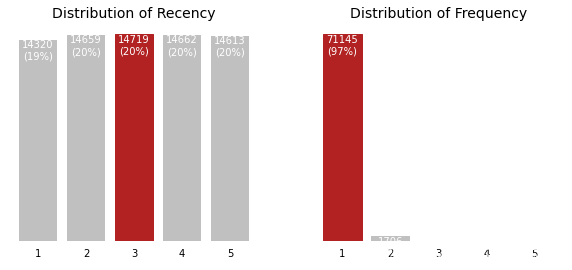

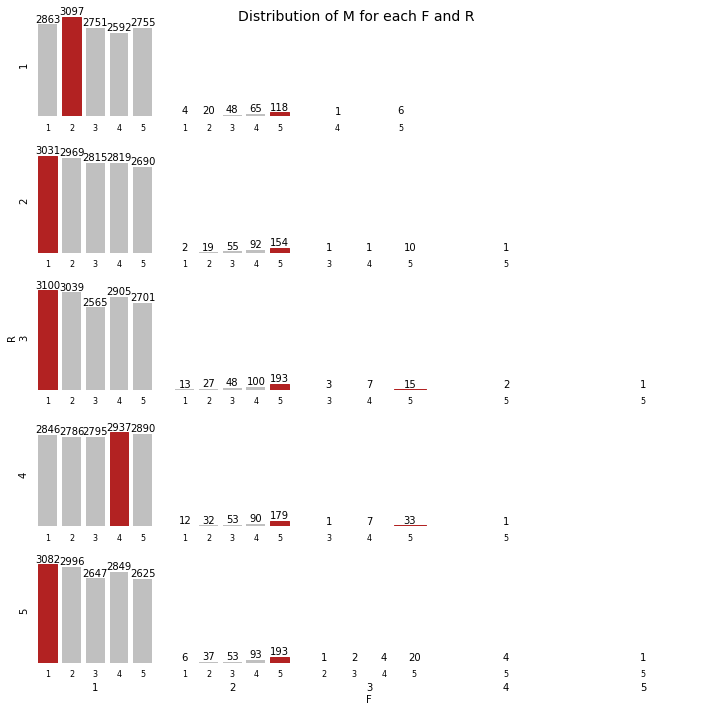

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = total_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = total_rfm[(total_rfm['R'] == r) & (total_rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()